[[  0.         100.9033977   84.42198794 243.74291632 107.30607331
   62.94926959 141.02937885 101.83079177 278.87542544 229.09130758
   85.02947343 255.27347121 304.56769587 144.29589293 110.85793079
  195.04991735 238.25855634]
 [100.9033977    0.         159.1215583  319.50119372 156.33163861
  106.54258433  58.5043835  159.72746828 200.5679617  157.88106283
  136.4872279  176.60106502 230.82389465 227.42728277  50.45737401
  109.61705042 249.33899235]
 [ 84.42198794 159.1215583    0.         179.78456979  93.05834669
   90.07443556 203.91764087 104.86895399 345.34926824 298.39322946
   84.45100501 323.58506315 374.08438994  79.32376551 171.26279798
  259.0776349  230.08426893]
 [243.74291632 319.50119372 179.78456979   0.         195.98072983
  234.43249782 362.60983517 189.69433759 512.38644556 456.28425444
  203.29503541 486.44623544 540.6353555  118.17879771 329.4449954
  406.56674467 231.98643683]
 [107.30607331 156.33163861  93.05834669 195.98072983   0.
   84.35608234 202.662

/tmp/ipykernel_2863447/2117198960.py:104: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(dist_matrix, method='ward')


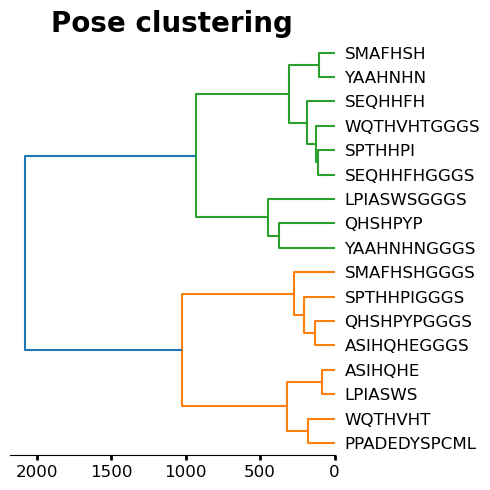

In [25]:
import numpy as np
# 导入scipy库中的层次聚类函数
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import fcluster
from pprint import pprint
from sklearn.decomposition import PCA 
import os
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# 生成20个20x3随机矩阵  
'''
data = [np.random.rand(20, 3) for _ in range(100)]

'''


np.set_printoptions(threshold=np.inf)
pdb_dir = '/mnt/sdc/lanwei/IL8/test/cluster/'

pdb_files = [os.path.join(pdb_dir, f) for f in os.listdir(pdb_dir) if f.endswith('.pdb')]

pdbs = {}
#读取pdb文件，将原子的位置信息转化为三维矩阵
for fpath in pdb_files:
    with open(fpath) as f:
        lines = f.readlines()
    coords = []
    for line in lines:
        if line.startswith('ATOM'):
            x, y, z = [float(line[i:i+8]) for i in range(30, 54, 8)]
            coords.append([x, y, z])
    pdbs[(os.path.basename(fpath)).split('.')[0]] = np.array(coords)

#pprint(pdbs)

dist_features = {}
n_components = 20 # 取前20个主成分 
for name, coord in pdbs.items():
    LSDM = []
    coord = pdbs[name]
    pca = PCA()
    pca.fit(coord)
    #左奇异分解矩阵
    #np.dot实现矩阵乘法计算,np.diag将一维奇异值数组转换为对角矩阵,两者结合可以重建出左奇异矩阵。
    DM = np.dot(pca.transform(coord), np.diag(pca.singular_values_))
    components = DM[:n_components, :]
    LSDM.append(components)
    dist_features[name] =  np.array(LSDM)  
#print(dist_features)


# 定义一个函数，计算两个矩阵之间的距离，这里使用欧氏距离
def matrix_distance(m1, m2):
    # 将两个矩阵展平为一维数组
    v1 = m1.flatten()
    v2 = m2.flatten()
    # 计算两个数组之间的欧氏距离
    return np.linalg.norm(v1 - v2)



keys = list(dist_features.keys()) 

dist_matrix = np.zeros((len(keys), len(keys)))

for i in range(len(keys)):
  for j in range(i+1, len(keys)):
    
    key1 = keys[i]
    key2 = keys[j]
    
    # 基于键取出数组值
    matrix1 = dist_features[key1]  
    matrix2 = dist_features[key2]
    diff = matrix1 - matrix2
    #dist = matrix_distance(matrix1, matrix2)
    rmsd = np.sqrt(np.mean(np.square(diff)))
    dist_matrix[i][j] = rmsd
    dist_matrix[j][i] = rmsd
#shape = dist_matrix.shape
print(dist_matrix)
'''
# 调用层次聚类函数，传入距离矩阵和聚类方法，这里使用平均距离法
#
kmeans = KMeans(n_clusters=4).fit(dist_matrix)
print(kmeans.labels_)

labels_name = []
for i in kmeans:
  labels_name.append(keys[i-1])
plt.scatter(range(17), range(17), c=labels_name) 
plt.title('Kmeans Cluster')
plt.show()

labels_name = []
for i in kmeans.labels_:
  labels_name.append(keys[i-1])
'''


Z = linkage(dist_matrix, method='ward')

# 调用fcluster函数，根据最大聚类数目来划分聚类，返回一个一维数组，表示每个矩阵的聚类标签
labelList = fcluster(Z, t=3, criterion='distance')
labels_name = []
for i in labelList:
  labels_name.append(keys[i-1])

print(labels_name)
plt.figure(figsize=(5,5))


ax1=plt.subplot()
o=dendrogram(Z,
            orientation='left',
            labels=labels_name,
            distance_sort='descending',
            show_leaf_counts=True)

ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.title('Pose clustering',fontsize=20,weight='bold')
plt.tick_params ('both',width=2,labelsize=12)
plt.tight_layout()
plt.show()


(17, 50, 3)
(17, 150)


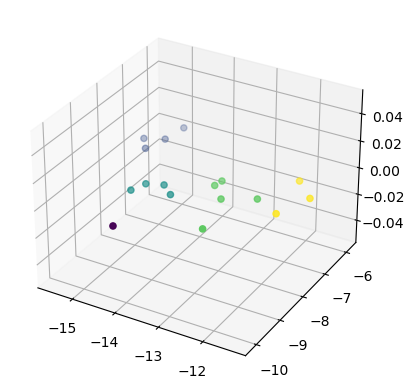

[3 2 3 4 4 3 2 4 1 1 3 1 1 3 2 2 0]


In [26]:
import numpy as np
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import os

np.set_printoptions(threshold=np.inf)
pdb_dir = '/mnt/sdc/lanwei/IL8/test/cluster/'

pdb_files = [os.path.join(pdb_dir, f) for f in os.listdir(pdb_dir) if f.endswith('.pdb')]

pdbs = {}
#读取pdb文件，将原子的位置信息转化为三维矩阵
for fpath in pdb_files:
    with open(fpath) as f:
        lines = f.readlines()
    coords = []
    for line in lines:
        if line.startswith('ATOM'):
            x, y, z = [float(line[i:i+8]) for i in range(30, 54, 8)]
            coords.append([x, y, z])
    pdbs[(os.path.basename(fpath)).split('.')[0]] = np.array(coords)

#pprint(pdbs)

dist_features = {}
n_components = 50 # 取前20个主成分 
for name, coord in pdbs.items():
    LSDM = []
    coord = pdbs[name]
    #print(coord)
    #matrix_shapes = [m.shape for m in coord]
    pca = PCA()
    pca.fit(coord)
    #左奇异分解矩阵
    #np.dot实现矩阵乘法计算,np.diag将一维奇异值数组转换为对角矩阵,两者结合可以重建出左奇异矩阵。
    DM = np.dot(pca.transform(coord), np.diag(pca.singular_values_))
    components = DM[:n_components, :]
    LSDM.append(components)
    dist_features[name] =  np.array(LSDM)  
#print(dist_features)




# Convert dictionary of LSDMs to array
X = np.array(list(dist_features.values())).squeeze()
print(X.shape)
X_2d = X.reshape(X.shape[0], -1)
X_2d = StandardScaler().fit_transform(X_2d)
print(X_2d.shape)
# Perform k-means clustering
kmeans = KMeans(n_clusters=5, max_iter=300, algorithm = 'lloyd', n_init=10)
labels = kmeans.fit_predict(X_2d)
# Perform t-SNE visualization
tsne = TSNE(n_components=2, perplexity=10, random_state=42)

X_tsne = tsne.fit_transform(X_2d)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_tsne[:, 0], X_tsne[:, 1],  c=labels)
plt.show()

print(labels)


In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.cluster import HDBSCAN

hdbscan  = HDBSCAN(min_cluster_size=6 )
hdb_labels = hdbscan.fit_predict(X_2d)

print(hdbscan)
tsne = TSNE(n_components=2, perplexity=5, random_state=42)

X_tsne = tsne.fit_transform(X_2d)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_tsne[:, 0], X_tsne[:, 1],  c=hdb_labels)
plt.show()
print(hdb_labels)

In [1]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.cluster import MeanShift
print(X_2d)
mean  = MeanShift( bin_seeding=True, cluster_all=False, min_bin_freq=1)
print(mean)
mean_labels = mean.fit_predict(X_2d)


tsne = TSNE(n_components=2, perplexity=5, random_state=42)

X_tsne = tsne.fit_transform(X_2d)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_tsne[:, 0], X_tsne[:, 1],  c=mean_labels)
plt.show()
print(hdb_labels)

NameError: name 'X_2d' is not defined

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

clusters_number = 4
# 原始数据
#X = np.array(list(dist_features.values())).squeeze() 
#X_2d = X.reshape(X.shape[0], -1)


# k-means聚类 
kmeans = KMeans(n_clusters=clusters_number, max_iter=300, algorithm='lloyd', n_init=10)
labels = kmeans.fit_predict(X_2d)

# t-SNE降维
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
X_tsne = tsne.fit_transform(X_2d)

# 2D散点图
fig, ax = plt.subplots()

# 生成不同类的dist_features键的列表
key_lists = [[] for i in range(clusters_number)]
for i, label in enumerate(labels):
    key_lists[label].append(list(dist_features.keys())[i])

# 绘制并以dist_features的键作为标签  
for i in range(clusters_number):
    ax.scatter(X_tsne[labels==i, 0], 
               X_tsne[labels==i, 1], 
               #label=key_lists[i]
               )
ax.legend()

plt.show()

cluster_keys = {}
for i in range(clusters_number):
    cluster_keys[i] = key_lists[i]

print(cluster_keys)